# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 08/04/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = int(config_hp["img_size"])
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = int(config_hp["batch_size"])
EPOCHS = int(config_hp["epochs"])
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

- The shape of the dataset is: (64, 64, 64, 3) => batch_size: 64, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


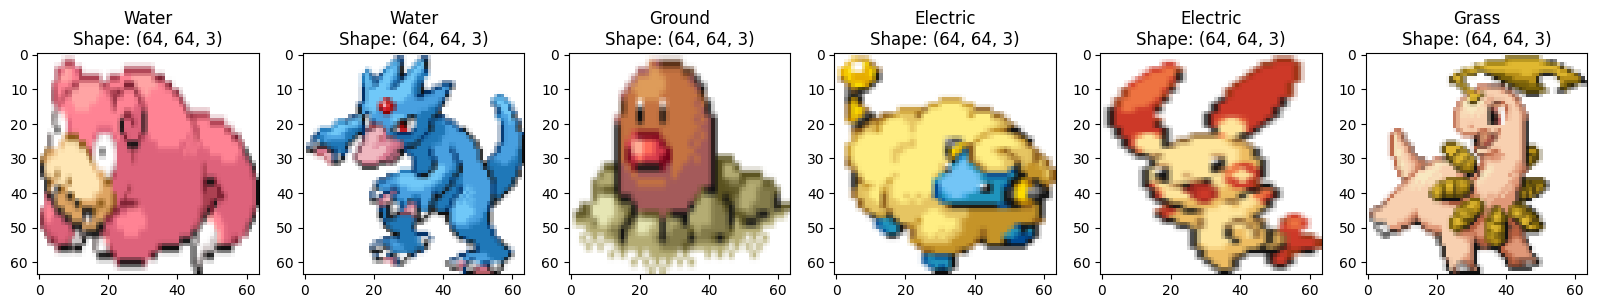

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [5]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/1000


I0000 00:00:1713901579.403171  105503 service.cc:145] XLA service 0x749438047d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713901579.403194  105503 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1713901579.832133  105503 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1713901581.293902  105826 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1713901581.906556  105818 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5377', 440 bytes spill stores, 440 bytes spill loads

I0000 00:00:1713901600.228450  105503 device_compiler.h:188] Com

127/127 ━━━━━━━━━━━━━━━━━━━━ 48s 169ms/step - loss: 0.4766
Epoch 2/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1691
Epoch 3/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0978
Epoch 4/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.1193
Epoch 5/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0724
Epoch 6/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0995
Epoch 7/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0981
Epoch 8/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0808
Epoch 9/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0905
Epoch 10/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0764
Epoch 11/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0592
Epoch 12/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0984
Epoch 13/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0665
Epoch 14/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0902


Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.10it/s]


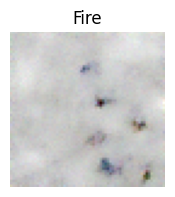

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - loss: 0.0652
Epoch 21/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0687
Epoch 22/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 23/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0863
Epoch 24/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0637
Epoch 25/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0589
Epoch 26/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0383
Epoch 27/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0734
Epoch 28/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0919
Epoch 29/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0674
Epoch 30/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 0.0703
Epoch 31/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0719
Epoch 32/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0575
Epoch 33/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.53it/s]


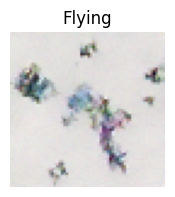

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 496ms/step - loss: 0.0451
Epoch 41/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0457
Epoch 42/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0800
Epoch 43/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0613
Epoch 44/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0392
Epoch 45/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0680
Epoch 46/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0631
Epoch 47/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0650
Epoch 48/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0674
Epoch 49/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0493
Epoch 50/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0425
Epoch 51/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0572
Epoch 52/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0562
Epoch 53/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.51it/s]


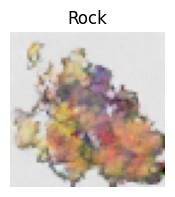

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 498ms/step - loss: 0.0480
Epoch 61/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0452
Epoch 62/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch 63/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 64/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0457
Epoch 65/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0714
Epoch 66/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0542
Epoch 67/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0535
Epoch 68/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0526
Epoch 69/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0577
Epoch 70/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0693
Epoch 71/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0619
Epoch 72/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0468
Epoch 73/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.40it/s]


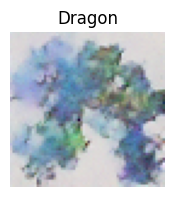

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 499ms/step - loss: 0.0570
Epoch 81/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0642
Epoch 82/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0484
Epoch 83/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0447
Epoch 84/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0503
Epoch 85/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0487
Epoch 86/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0482
Epoch 87/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0538
Epoch 88/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0847
Epoch 89/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0791
Epoch 90/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0592
Epoch 91/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0462
Epoch 92/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0405
Epoch 93/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss:

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.23it/s]


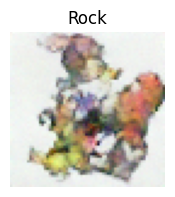

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0552
Epoch 101/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0525
Epoch 102/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0844
Epoch 103/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0622
Epoch 104/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0669
Epoch 105/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0338
Epoch 106/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0626
Epoch 107/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0409
Epoch 108/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0554
Epoch 109/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0408
Epoch 110/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0647
Epoch 111/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0626
Epoch 112/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0534
Epoch 113/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.30it/s]


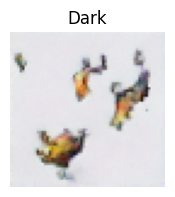

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - loss: 0.0586
Epoch 121/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0695
Epoch 122/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0573
Epoch 123/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0396
Epoch 124/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0646
Epoch 125/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch 126/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0673
Epoch 127/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0604
Epoch 128/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0587
Epoch 129/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0412
Epoch 130/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0643
Epoch 131/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0513
Epoch 132/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0421
Epoch 133/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.26it/s]


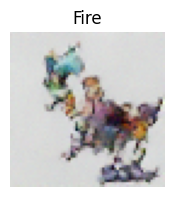

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0449
Epoch 141/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0389
Epoch 142/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0428
Epoch 143/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0337
Epoch 144/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0480
Epoch 145/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0861
Epoch 146/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0578
Epoch 147/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0643
Epoch 148/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0766
Epoch 149/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0611
Epoch 150/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0444
Epoch 151/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0507
Epoch 152/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0348
Epoch 153/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.90it/s]


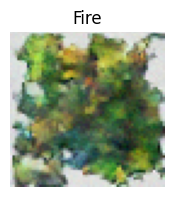

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 506ms/step - loss: 0.0726
Epoch 161/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0392
Epoch 162/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0397
Epoch 163/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0496
Epoch 164/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0350
Epoch 165/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0331
Epoch 166/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0465
Epoch 167/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 168/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0558
Epoch 169/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0710
Epoch 170/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 171/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0416
Epoch 172/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0370
Epoch 173/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.31it/s]


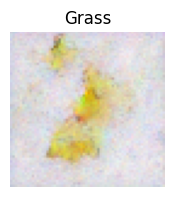

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - loss: 0.0543
Epoch 181/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0776
Epoch 182/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0567
Epoch 183/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0375
Epoch 184/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0399
Epoch 185/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0313
Epoch 186/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0389
Epoch 187/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0745
Epoch 188/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0531
Epoch 189/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0707
Epoch 190/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0512
Epoch 191/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0431
Epoch 192/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0568
Epoch 193/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.16it/s]


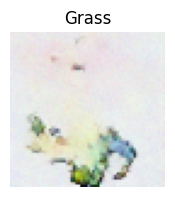

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 503ms/step - loss: 0.0345
Epoch 201/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0372
Epoch 202/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0453
Epoch 203/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0423
Epoch 204/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0393
Epoch 205/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0441
Epoch 206/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0294
Epoch 207/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0368
Epoch 208/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0417
Epoch 209/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0367
Epoch 210/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0382
Epoch 211/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0389
Epoch 212/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0397
Epoch 213/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.24it/s]


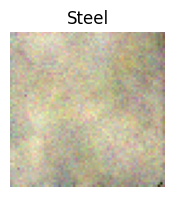

127/127 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - loss: 0.0541
Epoch 221/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0390
Epoch 222/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0400
Epoch 223/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0350
Epoch 224/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0391
Epoch 225/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0486
Epoch 226/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0679
Epoch 227/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0602
Epoch 228/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0499
Epoch 229/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0564
Epoch 230/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0405
Epoch 231/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0417
Epoch 232/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0369
Epoch 233/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.85it/s]


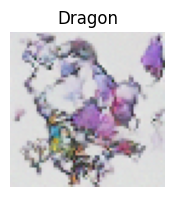

127/127 ━━━━━━━━━━━━━━━━━━━━ 68s 535ms/step - loss: 0.0349
Epoch 241/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - loss: 0.0330
Epoch 242/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.0482
Epoch 243/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0457
Epoch 244/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0388
Epoch 245/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0298
Epoch 246/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0426
Epoch 247/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0805
Epoch 248/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0501
Epoch 249/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0526
Epoch 250/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0366
Epoch 251/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0524
Epoch 252/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0444
Epoch 253/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.12it/s]


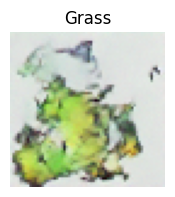

127/127 ━━━━━━━━━━━━━━━━━━━━ 67s 532ms/step - loss: 0.0489
Epoch 261/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.0428
Epoch 262/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0513
Epoch 263/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0438
Epoch 264/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0378
Epoch 265/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0370
Epoch 266/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - loss: 0.0381
Epoch 267/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0488
Epoch 268/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0624
Epoch 269/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0553
Epoch 270/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0408
Epoch 271/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - loss: 0.0411
Epoch 272/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - loss: 0.0398
Epoch 273/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms

Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.04it/s]


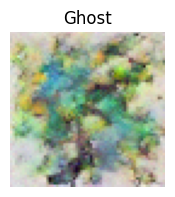

127/127 ━━━━━━━━━━━━━━━━━━━━ 67s 532ms/step - loss: 0.0741
Epoch 281/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.0415
Epoch 282/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.0494
Epoch 283/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0346
Epoch 284/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0368
Epoch 285/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0389
Epoch 286/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0395
Epoch 287/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0309
Epoch 288/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0595
Epoch 289/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0375
Epoch 290/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0677
Epoch 291/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - loss: 0.0561
Epoch 292/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0447
Epoch 293/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.70it/s]


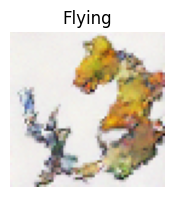

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 510ms/step - loss: 0.0605
Epoch 301/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0465
Epoch 302/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0267
Epoch 303/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0474
Epoch 304/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0387
Epoch 305/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0392
Epoch 306/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0423
Epoch 307/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0413
Epoch 308/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0392
Epoch 309/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0374
Epoch 310/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0272
Epoch 311/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0368
Epoch 312/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0555
Epoch 313/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.32it/s]


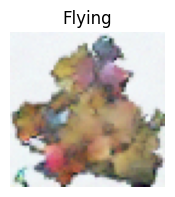

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0672
Epoch 321/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0614
Epoch 322/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 0.0420
Epoch 323/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0417
Epoch 324/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0390
Epoch 325/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0367
Epoch 326/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0419
Epoch 327/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0417
Epoch 328/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0497
Epoch 329/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0444
Epoch 330/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.0611
Epoch 331/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0462
Epoch 332/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0456
Epoch 333/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms

Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 22.72it/s]


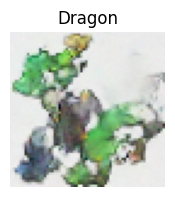

127/127 ━━━━━━━━━━━━━━━━━━━━ 67s 526ms/step - loss: 0.0414
Epoch 341/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0367
Epoch 342/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0391
Epoch 343/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0548
Epoch 344/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0457
Epoch 345/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0556
Epoch 346/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0344
Epoch 347/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0356
Epoch 348/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0456
Epoch 349/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0417
Epoch 350/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0511
Epoch 351/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0485
Epoch 352/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0364
Epoch 353/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.41it/s]


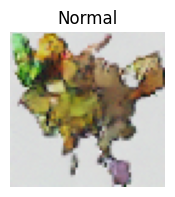

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0355
Epoch 361/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0319
Epoch 362/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0482
Epoch 363/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0374
Epoch 364/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0483
Epoch 365/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0399
Epoch 366/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0439
Epoch 367/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0406
Epoch 368/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0461
Epoch 369/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0424
Epoch 370/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0603
Epoch 371/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0505
Epoch 372/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0394
Epoch 373/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.27it/s]


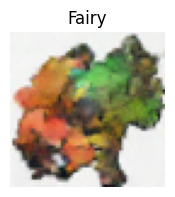

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 516ms/step - loss: 0.0420
Epoch 381/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0367
Epoch 382/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0651
Epoch 383/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0388
Epoch 384/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0394
Epoch 385/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0365
Epoch 386/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0544
Epoch 387/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0451
Epoch 388/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0311
Epoch 389/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0422
Epoch 390/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0379
Epoch 391/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0536
Epoch 392/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0494
Epoch 393/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.40it/s]


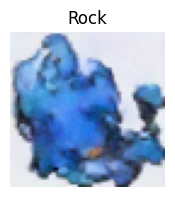

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0324
Epoch 401/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0322
Epoch 402/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0364
Epoch 403/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0260
Epoch 404/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0438
Epoch 405/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0453
Epoch 406/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0446
Epoch 407/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0481
Epoch 408/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0393
Epoch 409/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0237
Epoch 410/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0499
Epoch 411/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0330
Epoch 412/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0395
Epoch 413/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.24it/s]


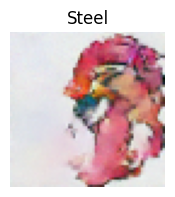

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - loss: 0.0429
Epoch 421/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0669
Epoch 422/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0383
Epoch 423/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0314
Epoch 424/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0425
Epoch 425/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0367
Epoch 426/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0363
Epoch 427/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0390
Epoch 428/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0292
Epoch 429/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0392
Epoch 430/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0382
Epoch 431/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0314
Epoch 432/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0367
Epoch 433/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.49it/s]


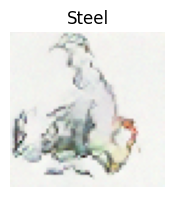

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - loss: 0.0387
Epoch 441/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0352
Epoch 442/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0656
Epoch 443/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0423
Epoch 444/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0388
Epoch 445/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0632
Epoch 446/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0457
Epoch 447/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0416
Epoch 448/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0425
Epoch 449/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0444
Epoch 450/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0284
Epoch 451/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0365
Epoch 452/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0324
Epoch 453/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.44it/s]


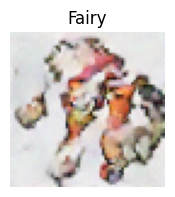

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0407
Epoch 461/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0357
Epoch 462/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0484
Epoch 463/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0477
Epoch 464/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0289
Epoch 465/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0530
Epoch 466/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0309
Epoch 467/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0391
Epoch 468/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0354
Epoch 469/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0313
Epoch 470/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0332
Epoch 471/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0371
Epoch 472/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0540
Epoch 473/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.23it/s]


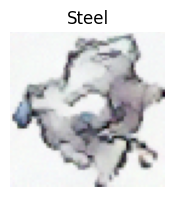

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - loss: 0.0353
Epoch 481/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0416
Epoch 482/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0336
Epoch 483/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0695
Epoch 484/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0417
Epoch 485/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0320
Epoch 486/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0400
Epoch 487/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0289
Epoch 488/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0324
Epoch 489/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0289
Epoch 490/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0348
Epoch 491/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0276
Epoch 492/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0281
Epoch 493/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.50it/s]


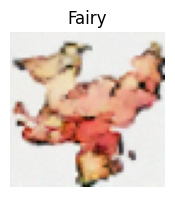

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - loss: 0.0456
Epoch 501/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0270
Epoch 502/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0770
Epoch 503/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0562
Epoch 504/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0345
Epoch 505/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0378
Epoch 506/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0420
Epoch 507/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0360
Epoch 508/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0403
Epoch 509/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0374
Epoch 510/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0319
Epoch 511/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0396
Epoch 512/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0334
Epoch 513/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.54it/s]


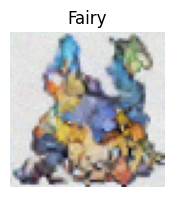

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0465
Epoch 521/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0436
Epoch 522/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0359
Epoch 523/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0596
Epoch 524/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0298
Epoch 525/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0387
Epoch 526/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0325
Epoch 527/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0328
Epoch 528/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0320
Epoch 529/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0343
Epoch 530/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0303
Epoch 531/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0445
Epoch 532/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0420
Epoch 533/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.58it/s]


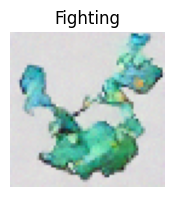

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0634
Epoch 541/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0351
Epoch 542/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0358
Epoch 543/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0329
Epoch 544/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0533
Epoch 545/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0477
Epoch 546/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0314
Epoch 547/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0361
Epoch 548/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0331
Epoch 549/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0699
Epoch 550/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0314
Epoch 551/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0329
Epoch 552/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0392
Epoch 553/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.59it/s]


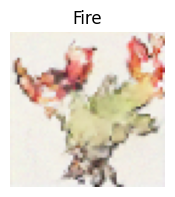

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0378
Epoch 561/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0378
Epoch 562/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0413
Epoch 563/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0401
Epoch 564/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0361
Epoch 565/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0376
Epoch 566/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0286
Epoch 567/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0257
Epoch 568/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0357
Epoch 569/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0299
Epoch 570/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0449
Epoch 571/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0473
Epoch 572/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0442
Epoch 573/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.44it/s]


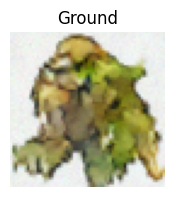

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - loss: 0.0268
Epoch 581/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0301
Epoch 582/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0429
Epoch 583/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0340
Epoch 584/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0390
Epoch 585/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0348
Epoch 586/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0371
Epoch 587/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0415
Epoch 588/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0398
Epoch 589/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0387
Epoch 590/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0549
Epoch 591/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0550
Epoch 592/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0346
Epoch 593/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.55it/s]


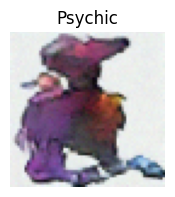

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0367
Epoch 601/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0301
Epoch 602/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0341
Epoch 603/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0323
Epoch 604/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0375
Epoch 605/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0322
Epoch 606/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0315
Epoch 607/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0365
Epoch 608/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0369
Epoch 609/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0378
Epoch 610/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0379
Epoch 611/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0378
Epoch 612/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0637
Epoch 613/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.71it/s]


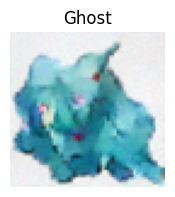

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 510ms/step - loss: 0.0296
Epoch 621/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0377
Epoch 622/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0347
Epoch 623/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0389
Epoch 624/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0533
Epoch 625/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0319
Epoch 626/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0380
Epoch 627/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0540
Epoch 628/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0313
Epoch 629/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0566
Epoch 630/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0316
Epoch 631/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0477
Epoch 632/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0347
Epoch 633/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.62it/s]


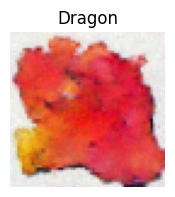

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 511ms/step - loss: 0.0635
Epoch 641/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0369
Epoch 642/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0329
Epoch 643/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0458
Epoch 644/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0469
Epoch 645/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0366
Epoch 646/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0255
Epoch 647/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0364
Epoch 648/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0355
Epoch 649/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0264
Epoch 650/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0288
Epoch 651/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0372
Epoch 652/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0408
Epoch 653/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.57it/s]


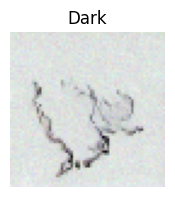

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0398
Epoch 661/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0425
Epoch 662/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0320
Epoch 663/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0300
Epoch 664/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0395
Epoch 665/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0430
Epoch 666/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0349
Epoch 667/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0383
Epoch 668/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0406
Epoch 669/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0348
Epoch 670/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0407
Epoch 671/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0379
Epoch 672/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0416
Epoch 673/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.27it/s]


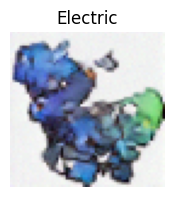

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 516ms/step - loss: 0.0358
Epoch 681/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0530
Epoch 682/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0337
Epoch 683/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0328
Epoch 684/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0295
Epoch 685/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0309
Epoch 686/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0416
Epoch 687/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0367
Epoch 688/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0265
Epoch 689/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0507
Epoch 690/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0422
Epoch 691/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0252
Epoch 692/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0385
Epoch 693/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.41it/s]


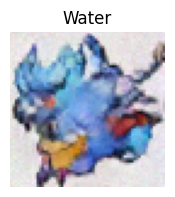

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0441
Epoch 701/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0331
Epoch 702/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0339
Epoch 703/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0308
Epoch 704/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0475
Epoch 705/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0365
Epoch 706/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 707/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0358
Epoch 708/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0289
Epoch 709/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0415
Epoch 710/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0404
Epoch 711/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0346
Epoch 712/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0508
Epoch 713/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.42it/s]


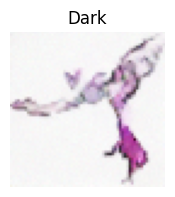

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0333
Epoch 721/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0327
Epoch 722/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0443
Epoch 723/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0292
Epoch 724/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0352
Epoch 725/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0388
Epoch 726/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0501
Epoch 727/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0497
Epoch 728/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0526
Epoch 729/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0433
Epoch 730/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0289
Epoch 731/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0314
Epoch 732/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0373
Epoch 733/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.38it/s]


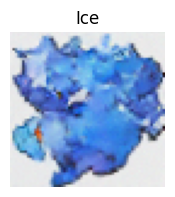

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0306
Epoch 741/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0622
Epoch 742/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0315
Epoch 743/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 744/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0372
Epoch 745/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0283
Epoch 746/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0248
Epoch 747/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0351
Epoch 748/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0291
Epoch 749/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0557
Epoch 750/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0451
Epoch 751/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0349
Epoch 752/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0316
Epoch 753/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.40it/s]


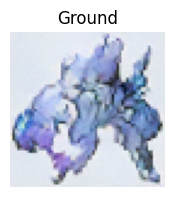

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0273
Epoch 761/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0678
Epoch 762/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0367
Epoch 763/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0356
Epoch 764/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0299
Epoch 765/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0336
Epoch 766/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0416
Epoch 767/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0311
Epoch 768/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0374
Epoch 769/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0372
Epoch 770/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0363
Epoch 771/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0444
Epoch 772/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0408
Epoch 773/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.40it/s]


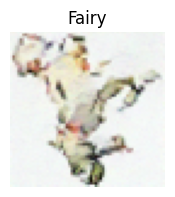

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0381
Epoch 781/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0296
Epoch 782/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0374
Epoch 783/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0398
Epoch 784/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0401
Epoch 785/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0316
Epoch 786/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0328
Epoch 787/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0230
Epoch 788/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0351
Epoch 789/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0314
Epoch 790/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0225
Epoch 791/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0355
Epoch 792/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0239
Epoch 793/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.25it/s]


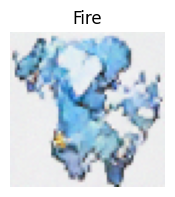

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 516ms/step - loss: 0.0298
Epoch 801/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0336
Epoch 802/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0357
Epoch 803/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0298
Epoch 804/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0423
Epoch 805/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0282
Epoch 806/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0323
Epoch 807/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0456
Epoch 808/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0369
Epoch 809/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0413
Epoch 810/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0332
Epoch 811/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0373
Epoch 812/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0531
Epoch 813/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:43<00:00, 23.15it/s]


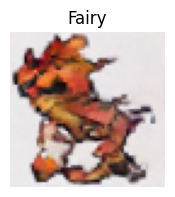

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - loss: 0.0498
Epoch 821/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0298
Epoch 822/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0361
Epoch 823/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0305
Epoch 824/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0369
Epoch 825/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0477
Epoch 826/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0414
Epoch 827/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0330
Epoch 828/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0382
Epoch 829/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0510
Epoch 830/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0378
Epoch 831/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0702
Epoch 832/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0368
Epoch 833/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.51it/s]


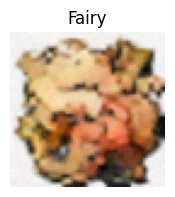

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 512ms/step - loss: 0.0272
Epoch 841/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0342
Epoch 842/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0356
Epoch 843/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0381
Epoch 844/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0308
Epoch 845/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0386
Epoch 846/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0419
Epoch 847/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0399
Epoch 848/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0378
Epoch 849/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0341
Epoch 850/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0435
Epoch 851/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0305
Epoch 852/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0331
Epoch 853/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.32it/s]


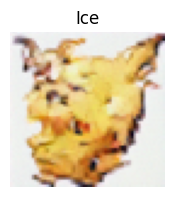

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - loss: 0.0338
Epoch 861/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0525
Epoch 862/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0350
Epoch 863/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0370
Epoch 864/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0407
Epoch 865/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0490
Epoch 866/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0448
Epoch 867/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0373
Epoch 868/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0355
Epoch 869/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0400
Epoch 870/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0511
Epoch 871/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0455
Epoch 872/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0360
Epoch 873/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.34it/s]


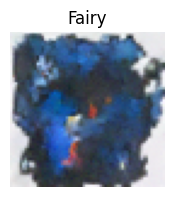

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - loss: 0.0419
Epoch 881/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0313
Epoch 882/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0512
Epoch 883/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0425
Epoch 884/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0432
Epoch 885/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0393
Epoch 886/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0315
Epoch 887/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0308
Epoch 888/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0278
Epoch 889/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0338
Epoch 890/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0435
Epoch 891/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0296
Epoch 892/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0316
Epoch 893/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.34it/s]


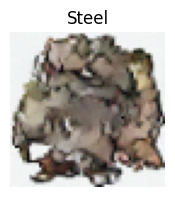

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 515ms/step - loss: 0.0455
Epoch 901/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0321
Epoch 902/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0325
Epoch 903/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0370
Epoch 904/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0353
Epoch 905/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0349
Epoch 906/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0466
Epoch 907/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0392
Epoch 908/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0394
Epoch 909/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0290
Epoch 910/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0275
Epoch 911/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0321
Epoch 912/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0337
Epoch 913/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.75it/s]


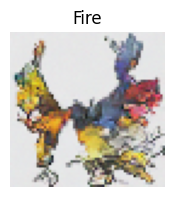

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 509ms/step - loss: 0.0289
Epoch 921/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0279
Epoch 922/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0377
Epoch 923/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0354
Epoch 924/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0285
Epoch 925/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0409
Epoch 926/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0384
Epoch 927/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0285
Epoch 928/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0328
Epoch 929/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0233
Epoch 930/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0318
Epoch 931/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0190
Epoch 932/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0250
Epoch 933/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.67it/s]


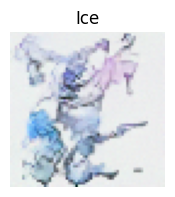

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 510ms/step - loss: 0.0214
Epoch 941/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0271
Epoch 942/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0265
Epoch 943/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0352
Epoch 944/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0466
Epoch 945/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - loss: 0.0345
Epoch 946/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0373
Epoch 947/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0344
Epoch 948/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0362
Epoch 949/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0534
Epoch 950/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0602
Epoch 951/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0369
Epoch 952/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0294
Epoch 953/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.64it/s]


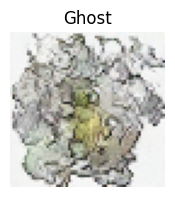

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 510ms/step - loss: 0.0369
Epoch 961/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0359
Epoch 962/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0240
Epoch 963/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0359
Epoch 964/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0312
Epoch 965/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0277
Epoch 966/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0705
Epoch 967/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0354
Epoch 968/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0306
Epoch 969/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0307
Epoch 970/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0511
Epoch 971/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0464
Epoch 972/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0298
Epoch 973/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.37it/s]


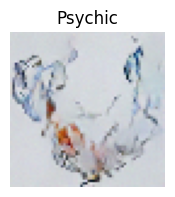

127/127 ━━━━━━━━━━━━━━━━━━━━ 65s 514ms/step - loss: 0.0271
Epoch 981/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - loss: 0.0349
Epoch 982/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0388
Epoch 983/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0294
Epoch 984/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0460
Epoch 985/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0339
Epoch 986/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0295
Epoch 987/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0266
Epoch 988/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0295
Epoch 989/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0502
Epoch 990/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0416
Epoch 991/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0446
Epoch 992/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 0.0347
Epoch 993/1000
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms

Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.68it/s]


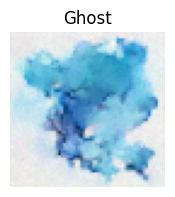

127/127 ━━━━━━━━━━━━━━━━━━━━ 64s 510ms/step - loss: 0.0397


In [6]:
model.fit(poke_dataset, epochs=1000, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.92it/s]


Generating sample 2/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.15it/s]


Generating sample 3/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 23.94it/s]


Generating sample 4/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.24it/s]


Generating sample 5/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.10it/s]


Generating sample 6/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.46it/s]


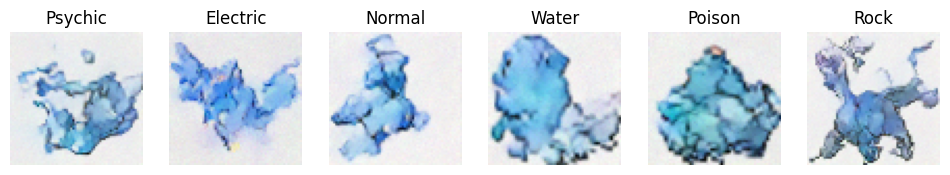

Generating sample 1/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.59it/s]


Generating sample 2/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.56it/s]


Generating sample 3/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.55it/s]


Generating sample 4/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.80it/s]


Generating sample 5/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.68it/s]


Generating sample 6/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.58it/s]


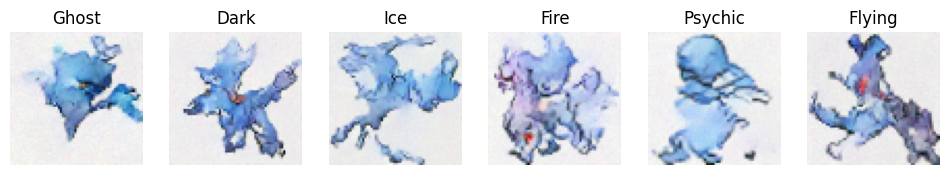

Generating sample 1/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.89it/s]


Generating sample 2/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.64it/s]


Generating sample 3/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.58it/s]


Generating sample 4/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.35it/s]


Generating sample 5/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.62it/s]


Generating sample 6/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.85it/s]


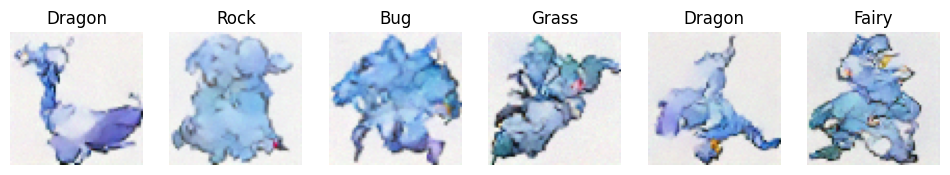

Generating sample 1/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.74it/s]


Generating sample 2/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.29it/s]


Generating sample 3/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.69it/s]


Generating sample 4/6


Sampling sprite: 100%|██████████| 999/999 [00:39<00:00, 25.11it/s]


Generating sample 5/6


Sampling sprite: 100%|██████████| 999/999 [00:40<00:00, 24.50it/s]


Generating sample 6/6


Sampling sprite: 100%|██████████| 999/999 [00:41<00:00, 24.31it/s]


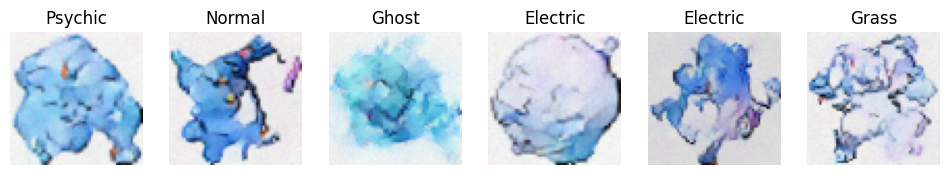

In [7]:
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)
model.plot_samples(6)

In [11]:
# Save the model
# =====================================================================
model.save("../models/ddpm_linear_64_1000.h5")

# Load the model
# =====================================================================
# model = DiffusionModel.load("ddpm_linear_64_1000.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [12]:
# Save the model using mlflow
# =====================================================================
import mlflow

mlflow.tensorflow.save_model(model, "../models/ddpm_linear_64_1000_mlflow")

# Load the model using mlflow
# =====================================================================
# loaded = mlflow.tensorflow.load_model("../models/ddpm_linear_64_1000_mlflow")

2024/04/24 05:20:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/home/pqlza/.local/lib/python3.11/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
2024/04/24 05:20:10 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /workspaces/tf-diffusion-scratch/models/ddpm_linear_64_1000_mlflow, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is repla

In [13]:
# save the model using pickle
# =====================================================================
import pickle

with open("../models/ddpm_linear_64_1000_.pkl", "wb") as f:
    pickle.dump(model, f)

# Load the model using pickle
# =====================================================================
# with open("../models/ddpm_linear_64_1000.pkl", "rb") as f:
#     model = pickle.load(f)

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [8]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [9]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [10]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)